# Template — MVP: *Machine Learning & Analytics*
**Autor:** Rafael Theodoro Rocha  

**Data:** 28/09/2025

**Matrícula:** 4052025001358
---



## ✅ Checklist do MVP (o que precisa conter)
- [✅] **Problema definido** e contexto de negócio
- [✅] **Carga e preparação** dos dados (sem vazamento de dados)
- [✅] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [✅] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [✅] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [✅] **Otimização de hiperparâmetros**
- [✅] **Avaliação** com **métricas adequadas** e discussão de limitações
- [✅] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [✅] **Pipelines reprodutíveis** (sempre que possível)

# 1. Escopo, Objetivo e Definição do Problema

## Contexto e Objetivo
O objetivo do projeto é **prever se um usuário irá curtir uma música** com base em características da faixa (ex.: `danceability`, `energy`, `year`, `acousticness`).  
A previsão permite personalizar recomendações musicais e melhorar a experiência do usuário, priorizando músicas que ele tem maior probabilidade de gostar.

## Tipo de Tarefa
- **Classificação binária**: a variável alvo é `liked` (1 = curtida, 0 = não curtida).

## Área de Aplicação
- Dados tabulares provenientes de músicas e comportamento do usuário.
- Aplicação em **recomendação musical**, análise de preferências e personalização de playlists.

## Valor para o Negócio / Usuário
- Identificar músicas que o usuário realmente irá curtir, aumentando **engajamento e satisfação**.
- Permitir **personalização de playlists** e **ranking refinado de recomendações**.
- Possibilitar futuras evoluções do sistema, combinando classificação com **modelos probabilísticos** e **clustering de estilos musicais** para recomendações híbridas.


## 2. Reprodutibilidade e ambiente

In [108]:
# === Setup básico e reprodutibilidade ===
import os
import sys
import random
import time
import math
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)


Python: 3.12.11
Seed global: 42


# 3 Extração e Origem dos Dados

**Versão:** 1.0

Este projeto utiliza um modelo de **classificação supervisionada** para prever se uma música será curtida (`liked`) ou não, com base em suas características sonoras e metadados.

## Fonte de Dados

As músicas utilizadas para treinamento e avaliação do modelo foram coletadas a partir da biblioteca do usuário no Spotify, utilizando dois endpoints da API oficial do Spotify:

- Músicas curtidas: `GET https://api.spotify.com/v1/me/tracks`
- Músicas mais ouvidas: `GET https://api.spotify.com/v1/me/top/tracks`

Os dados foram armazenados localmente em arquivos `.json` e processados para compor os datasets de entrada do modelo.  
A documentação completa da API do Spotify está disponível em: https://developer.spotify.com/documentation/web-api

## Features das Músicas

Inicialmente, a extração de características sonoras das faixas (como `danceability`, `energy`, `valence`, etc.) seria realizada por meio dos endpoints:

- Track's Audio Features: `GET https://api.spotify.com/v1/audio-features/{id}`  
- Track's Audio Analysis: `GET https://api.spotify.com/v1/audio-analysis/{id}`

Como estes endpoints foram oficialmente depreciados, optou-se por utilizar datasets públicos disponíveis no **Kaggle**, contendo as features previamente extraídas.  
Esses dados foram cruzados com os dados das músicas do usuário para construir o dataset final.

> **Observação:** Nem todas as músicas do usuário (curtidas ou mais ouvidas) estavam presentes nos datasets públicos, reduzindo o tamanho final do DataFrame para treinamento.

## Dataset Consolidado

Após o processamento, foi criado o DataFrame principal contendo:

- Colunas de metadados (`track_name`, `artists`, `track_id`)  
- Features numéricas para modelagem  
- Variável alvo (`liked`), binária


# 3.1 Extração das Músicas Curtidas e Mais Ouvidas

**Versão:** 1.0

Os dados das músicas do usuário foram extraídos em lotes da API do Spotify.

## Extração de Músicas Curtidas (`/v1/me/tracks`)

Os dados das músicas curtidas do usuário foram extraídos em lotes utilizando o endpoint `/v1/me/tracks` da API do Spotify, que retorna as faixas salvas na biblioteca do usuário.

Os dados coletados foram armazenados localmente em arquivos `.json` paginados:

```python
arquivos_musicas_curtidas = [
    "musicas_curtidas-1-50.json",
    "musicas_curtidas-51-100.json",
    "musicas_curtidas-101-150.json",
    "musicas_curtidas-151-200.json",
    "musicas_curtidas-201-250.json"
]


In [109]:
base_url = "https://raw.githubusercontent.com/rafatheodoro/mvp-machine-learning/main/"

arquivos_musicas_curtidas = [
    "musicas_curtidas-1-50.json",
    "musicas_curtidas-51-100.json",
    "musicas_curtidas-101-150.json",
    "musicas_curtidas-151-200.json",
    "musicas_curtidas-201-250.json"
]

# Monta a lista completa de URLs
urls_musicas_curtidas = [base_url + nome for nome in arquivos_musicas_curtidas]

def carregar_musicas_curtidas(urls_json):
    todas_musicas = []
    for url in urls_json:
        response = requests.get(url)  # baixa o arquivo
        response.raise_for_status()   # gera erro se a URL estiver inválida
        data = response.json()        # carrega o JSON direto da URL
        for item in data.get("items", []):
            track = item.get("track")
            if track:
                todas_musicas.append(track)
    return todas_musicas

todas_musicas_curtidas = carregar_musicas_curtidas(urls_musicas_curtidas)

# Extrai nome, ID, artistas, duração e popularidade das faixas
def extrair_colunas_relevantes(tracks):
    return pd.DataFrame([{
        "track_name": track.get("name"),
        "track_id": track.get("id"),
        "artists": ", ".join([artist["name"] for artist in track.get("artists", [])]),
        "duration_ms": track.get("duration_ms"),
        "popularity": track.get("popularity")
    } for track in tracks])

df_musicas_curtidas = extrair_colunas_relevantes(todas_musicas_curtidas)

df_musicas_curtidas.head()

,track_name,track_id,artists,duration_ms,popularity
0,In the End,60a0Rd6pjrkxjPbaKzXjfq,Linkin Park,216880,88
1,American Idiot,45zvStEMsXp8z45OQRhWFJ,Green Day,174320,61
2,All My Life,6tsojOQ5wHaIjKqIryLZK6,Foo Fighters,263440,72
3,Want You Bad,6hwQ69v7VbPhTTR2fOtYX7,The Offspring,202573,73
4,Chop Suey!,2DlHlPMa4M17kufBvI2lEN,System Of A Down,210240,85


## Extração de Músicas Mais Ouvidas (`/v1/me/top/tracks`)

Os dados foram extraídos em lotes da API do Spotify utilizando o endpoint `/v1/me/top/tracks`, que retorna as músicas mais ouvidas pelo usuário autenticado.

Os dados foram armazenados localmente em arquivos `.json` paginados:

```python
arquivos_musicas_ouvidas = [
    "musicas_ouvidas-1-50.json",
    "musicas_ouvidas-51-100.json",
    "musicas_ouvidas-101-150.json",
    "musicas_ouvidas-151-200.json",
    "musicas_ouvidas-201-250.json",
    "musicas_ouvidas-251-300.json",
    "musicas_ouvidas-301-350.json",
    "musicas_ouvidas-351-400.json",
    "musicas_ouvidas-401-450.json",
    "musicas_ouvidas-451-500.json",
    "musicas_ouvidas-501-550.json"
]

Observação: Algumas músicas curtidas também estão presentes nesse conjunto. Portanto, para garantir o balanceamento entre músicas curtidas (liked = 1) e não curtidas (liked = 0), utilizou-se um conjunto maior de músicas ouvidas.
Além disso, não foram encontradas features para todas as músicas curtidas e ouvidas do usuário, o que fez com que o dataset final (df_musicas) fosse reduzido.

In [110]:
# Arquivos das músicas ouvidas
arquivos_musicas_ouvidas = [
    "musicas_ouvidas-1-50.json",
    "musicas_ouvidas-51-100.json",
    "musicas_ouvidas-101-150.json",
    "musicas_ouvidas-151-200.json",
    "musicas_ouvidas-201-250.json",
    "musicas_ouvidas-251-300.json",
    "musicas_ouvidas-301-350.json",
    "musicas_ouvidas-351-400.json",
    "musicas_ouvidas-401-450.json",
    "musicas_ouvidas-451-500.json",
    "musicas_ouvidas-551-600.json",
    "musicas_ouvidas-601-650.json",
    "musicas_ouvidas-651-700.json"
]

# Monta as URLs
urls_musicas_ouvidas = [base_url + nome for nome in arquivos_musicas_ouvidas]

# Função para carregar músicas ouvidas
def carregar_musicas_ouvidas(urls_json):
    todas_musicas = []
    for url in urls_json:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        for item in data.get("items", []):
            todas_musicas.append(item)
    return todas_musicas

# Carregar e processar músicas ouvidas
todas_musicas_ouvidas = carregar_musicas_ouvidas(urls_musicas_ouvidas)

df_musicas_ouvidas = extrair_colunas_relevantes(todas_musicas_ouvidas)

df_musicas_ouvidas.head()


,track_name,track_id,artists,duration_ms,popularity
0,Wheels,3KsatAMRt1a7iryhWt5I8U,Foo Fighters,278213,60
1,With Arms Wide Open,0eKyHwckh9vQb8ncZ2DXCs,Creed,274800,75
2,Higher,1ZozJfi8u9cO2Ob8KwiwNT,Creed,316733,78
3,O Universo A Nosso Favor,3YbhQokqKwFuDTS7mwWgmP,"Charlie Brown Jr., Forfun",261880,48
4,My Sacrifice,2VSbEXqs6NbNiZSTcHlIDR,Creed,294600,76


## 3.2 Montagem do DataFrame das Músicas com Rótulo (Target)

Após a extração das músicas curtidas (`/v1/me/tracks`) e das músicas mais ouvidas (`/v1/me/top/tracks`), os dados foram organizados em dois dataframes:

- `df_musicas_curtidas`: músicas curtidas (salvas) pelo usuário.  
- `df_musicas_ouvidas`: músicas mais ouvidas pelo usuário.

Para treinar o modelo de classificação supervisionado, foi criada a variável alvo `liked`, que indica se uma música foi curtida (`liked = 1`) ou não (`liked = 0`).  
Essa coluna será utilizada como **target** no treinamento do modelo.

Os dois conjuntos foram então combinados no dataframe `df_musicas`, que contém as seguintes colunas:

- `track_id`  
- `track_name`  
- `artists`  
- `duration_ms`  
- `popularity`  
- `liked` (variável alvo)


In [111]:
df_musicas_curtidas['liked'] = 1  # Curtidas (liked = 1)
df_musicas_ouvidas['liked'] = 0   # Apenas ouvidas (liked = 0)

df_musicas = pd.concat(
    [df_musicas_curtidas, df_musicas_ouvidas],
    ignore_index=True
)

# Mantém a versão 'curtida' (liked=1), se a música estiver duplicada
df_musicas = (
    df_musicas
    .sort_values("liked", ascending=False)  # Garante que liked=1 venha primeiro
    .drop_duplicates(subset=["track_id"], keep="first")
    .reset_index(drop=True)
)

# Distribuição da váriavel alvo (liked)
df_musicas['liked'].value_counts()

,count
liked,
0,587
1,231


# 3. Enriquecimento com Audio Features

Para enriquecer o dataset com características de áudio das músicas curtidas e ouvidas, foram utilizados diversos datasets públicos do Kaggle. Isso foi necessário porque os endpoints da API do Spotify que forneciam essas informações foram descontinuados.

## Datasets utilizados

Foram utilizados os seguintes arquivos CSV como fontes complementares de dados:

| Dataset                  | Descrição                                  |
|--------------------------|--------------------------------------------|
| `tracks_features.csv`     | Contém features de faixas diversas.        |
| `ultimateClassicRock.csv` | Contém features de faixas de rock clássico.|
| `spotify-1990.csv`        | Contém features de faixas lançadas nos anos 1990. |
| `spotify-2000.csv`        | Contém features de faixas lançadas nos anos 2000. |
| `audioFeatures.csv`       | Contém features de faixas diversas.       |

## Tratamentos realizados

Como os datasets foram extraídos de fontes distintas, foi necessário realizar padronizações antes da junção com o dataset principal:

- Normalização dos nomes de colunas para letras minúsculas  
- Renomeação de colunas para unificação:  
  - `id` → `track_id`  
  - `artist` / `artist_name` → `artists`  
  - `title` / `track` / `name` → `track_name`  
- Junção dos dados com o dataframe `df_musicas`, utilizando as colunas disponíveis para garantir o máximo de correspondência

## Dataset final com audio features

Os dados foram consolidados no dataframe:

```python
df_musicas_features


In [112]:
import pandas as pd

# Base URL
base_url = "https://raw.githubusercontent.com/rafatheodoro/mvp-machine-learning/main/"

# --- Dataset track_features ---
df_track_features = pd.read_csv(base_url + "tracks_features.csv")
df_track_features.columns = df_track_features.columns.str.lower()
df_track_features.rename(columns={'id':'track_id', 'name': 'track_name'}, inplace=True)

# Merge com df_musicas (assumindo df_musicas já carregado)
df_features_merged_musicas = pd.merge(
    df_track_features,
    df_musicas[['track_id', 'liked']],
    on='track_id',
    how='inner'
)

# --- Datasets adicionais tratados separadamente ---

# Dataset Rock
df_features_rock = pd.read_csv(base_url + "ultimateClassicRock.csv")
df_features_rock.columns = df_features_rock.columns.str.lower()
df_features_rock.rename(columns={'track': 'track_name', 'artist': 'artists'}, inplace=True)

# Dataset 1990
df_features_1990 = pd.read_csv(base_url + "spotify-1990.csv")
df_features_1990.columns = df_features_1990.columns.str.lower()
df_features_1990.rename(columns={'track': 'track_name', 'artist': 'artists'}, inplace=True)

# Dataset 2000
df_features_2000 = pd.read_csv(base_url + "spotify-2000.csv")
df_features_2000.columns = df_features_2000.columns.str.lower()
df_features_2000.rename(columns={'title': 'track_name', 'artist': 'artists', 'loudness (db)': 'loudness'}, inplace=True)

# --- Consolidação dos datasets adicionais e merge com df_musicas ---
dfs_outras_features_merged_musicas = pd.concat([df_features_rock, df_features_1990, df_features_2000], ignore_index=True)

dfs_outras_features_merged_musicas = pd.merge(
    dfs_outras_features_merged_musicas,
    df_musicas[['track_id', 'track_name', 'artists', 'liked']],
    on=['track_name', 'artists'],
    how='inner'
)

# --- Dataframe final para treinamento e teste ---
df_musicas_features = pd.concat([df_features_merged_musicas, dfs_outras_features_merged_musicas], ignore_index=True)

# Visualizar a distribuição da variável alvo
print(df_musicas_features['liked'].value_counts())

liked
0    115
1    113
Name: count, dtype: int64


# 4. Seleção das Features para o Modelo

Para a construção do modelo preditivo, selecionamos um conjunto de variáveis numéricas que representam características relevantes das faixas de áudio, além de variáveis auxiliares para análise e identificação.  
A variável alvo é **`liked`**, indicando se uma música foi curtida (`1`) ou não (`0`).

As variáveis de identificação e rótulo incluem:

- `track_id`: identificador único da música  
- `track_name`: nome da música  
- `artists`: artista(s) responsáveis pela música  
- `liked`: variável **alvo** do modelo supervisionado (1 = curtida, 0 = não curtida)  

As variáveis de áudio (features numéricas) selecionadas foram:

- **acousticness**: grau de sonoridade acústica da música (0 a 1)  
- **danceability**: quão dançável a música é (0 a 1)  
- **energy**: intensidade e atividade da faixa (0 a 1)  
- **liveness**: presença de público ao vivo (0 a 1)  
- **loudness**: volume médio da música em decibéis (valores geralmente negativos)  
- **speechiness**: presença de elementos falados na faixa (0 a 1)  
- **valence**: positividade ou alegria percebida na música (0 a 1)  
- **year**: ano de lançamento da música — pode capturar tendências temporais  

💡 **Nota:** Todas as variáveis utilizadas são **numéricas e contínuas**, simplificando o pré-processamento, já que não há necessidade de codificação categórica.

Durante a construção do modelo, foi realizada uma **seleção criteriosa** das variáveis, considerando relevância preditiva, consistência e tipo de informação representada.  

As variáveis mantidas no modelo foram:

- `acousticness`, `danceability`, `energy`, `liveness`, `loudness`, `speechiness`, `valence`, `year`  
- Metadados: `track_id`, `track_name`, `artists`  
- Variável alvo: `liked`  

As variáveis removidas e justificativas:

- **Gênero, popularidade e metadata**: `top genre`, `artist_ids`, `album_id`, `explicit`, `popularity`  
  - Categorias inconsistentes ou externas, podendo introduzir viés  
- **Tempo, duração e métricas relacionadas**: `duration_ms`, `duration`, `length (duration)`, `tempo`, `beats per minute (bpm)`, `time_signature`  
  - Redundantes e de baixo poder discriminativo  
- **Técnicas ou de baixa relevância**: `instrumentalness`, `key`, `mode`, `track_number`, `disc_number`, `release_date`  
  - Pouco relacionadas à preferência do usuário ou substituídas por `year`  

Após o merge e a seleção de features, o **DataFrame final** apresenta:

- ✅ Nenhum valor ausente (*missing values*)  
- ✅ Variáveis categóricas normalizadas  
- ✅ Sem necessidade de limpeza adicional  

Essas condições permitem um **pipeline de modelagem mais limpo e eficiente**.


In [113]:
features_selecionadas = [
    'track_id', 'artists', 'track_name', 'liked',
    'acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'valence', 'year'
]

df_musicas_features = df_musicas_features[features_selecionadas]

# Verificação final
df_musicas_features.info()
df_musicas_features['liked'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   track_id      228 non-null    object 
 1   artists       228 non-null    object 
 2   track_name    228 non-null    object 
 3   liked         228 non-null    int64  
 4   acousticness  228 non-null    float64
 5   danceability  228 non-null    float64
 6   energy        228 non-null    float64
 7   liveness      228 non-null    float64
 8   loudness      228 non-null    float64
 9   speechiness   228 non-null    float64
 10  valence       228 non-null    float64
 11  year          228 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 21.5+ KB


,count
liked,
0,115
1,113


# 5. Fase de Modelagem e Treino

Nesta etapa, utilizamos as variáveis extraídas e tratadas para treinar um modelo de machine learning capaz de prever se uma música será **curtida** (`liked = 1`) ou **não curtida** (`liked = 0`), com base em suas características de áudio.

Foram geradas **duas visões do dataset** para avaliar o impacto da variável temporal `year`:


In [114]:
colunas_com_year = [
    'acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'valence', 'year'
]

colunas_sem_year = [
        'acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'valence'
]

# X e y para os dois cenários
X_com_year = df_musicas_features[colunas_com_year]
X_sem_year = df_musicas_features[colunas_sem_year]
y = df_musicas_features['liked']

df_musicas_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   track_id      228 non-null    object 
 1   artists       228 non-null    object 
 2   track_name    228 non-null    object 
 3   liked         228 non-null    int64  
 4   acousticness  228 non-null    float64
 5   danceability  228 non-null    float64
 6   energy        228 non-null    float64
 7   liveness      228 non-null    float64
 8   loudness      228 non-null    float64
 9   speechiness   228 non-null    float64
 10  valence       228 non-null    float64
 11  year          228 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 21.5+ KB


## Divisão entre Treino e Teste

Foi adotada a estratégia padrão de separar 80% dos dados para treino e 20% para teste, mantendo a proporção da variável alvo (stratify=y).


In [115]:
# Com 'year'
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
    X_com_year, y, test_size=0.2, stratify=y, random_state=42
)

# Sem 'year'
X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(
    X_sem_year, y, test_size=0.2, stratify=y, random_state=42
)

## Seleção de Modelos de Classificação e Treinamento

| Modelo                  | Tipo                        | Motivo da Escolha |
|-------------------------|----------------------------|-----------------|
| Logistic Regression     | Linear, classificação binária | Simples, interpretável, serve como baseline. Funciona bem com features numéricas contínuas. |
| Random Forest           | Ensemble de árvores (Bagging) | Captura relações não lineares, robusto a ruído, permite avaliar importância das features. |
| XGBoost                 | Gradient Boosting sobre árvores | Modelo avançado, alto desempenho, otimiza erros sequencialmente, bom para métricas como F1-score. |

> A combinação permite comparar desempenho de modelos simples e complexos e verificar se variáveis como `year` melhoram a predição.


In [116]:
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def treinar_modelo(modelo, X_train, y_train, X_test):

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_probs = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    return y_pred, y_probs

#===============================
# Logistic Regression
# ================================
lr = LogisticRegression(max_iter=1000, random_state=42)

y_pred_lr_year, y_probs_lr_year = treinar_modelo(lr, X_train_year, y_train_year, X_test_year)
y_pred_lr_no_year, y_probs_lr_no_year = treinar_modelo(lr, X_train_no_year, y_train_no_year, X_test_no_year)

# ================================
# Random Forest
# ================================
rf = RandomForestClassifier(n_estimators=200, random_state=42)

y_pred_rf_year, y_probs_rf_year = treinar_modelo(rf, X_train_year, y_train_year, X_test_year)
y_pred_rf_no_year, y_probs_rf_no_year = treinar_modelo(rf, X_train_no_year, y_train_no_year, X_test_no_year)

# ================================
# XGBoost
# ================================
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

y_pred_xgb_year, y_probs_xgb_year = treinar_modelo(xgb, X_train_year, y_train_year, X_test_year)
y_pred_xgb_no_year, y_probs_xgb_no_year = treinar_modelo(xgb, X_train_no_year, y_train_no_year, X_test_no_year)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:00:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:00:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Avaliação do Modelo

A função `avaliar_modelo_completo` avalia modelos de **classificação binária** (0 = não curtida, 1 = curtida) combinando **visualizações e métricas quantitativas**.

### Métricas Escolhidas
- **Matriz de Confusão:** identifica acertos e erros por classe.  
- **Precision (classe positiva):** proporção de curtidas corretamente previstas, evitando falsos positivos.  
- **Recall (classe positiva):** proporção de curtidas reais capturadas, garantindo cobertura.  
- **F1-score:** balanceia precision e recall.  
- **Accuracy:** acurácia geral do modelo.

> Essas métricas permitem comparar desempenho, avaliar a capacidade de prever curtidas e analisar o impacto de diferentes features, como `year`.


In [117]:
def avaliar_modelo(y_test, y_pred, label):
    print(f"\n=== Avaliação {label} ===")

    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Real 0 (não curtida)", "Real 1 (curtida)"],
        columns=["Predito 0", "Predito 1"]
    )
    print("\n📌 Matriz de Confusão:")
    print(cm_df)

    # --- Relatório de Classificação ---
    print("\n📌 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=["Não curtida", "Curtida"]))

    # --- Heatmap ---
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predito 0", "Predito 1"],
                yticklabels=["Real 0 (não curtida)", "Real 1 (curtida)"])
    plt.title(f"Matriz de Confusão - {label}")
    plt.ylabel("Real")
    plt.xlabel("Predito")
    plt.show()

    # --- Métricas principais ---
    report_dict = classification_report(y_test, y_pred, output_dict=True, labels=[0, 1])

    # Acessa a classe positiva independentemente do tipo da chave (str ou int)
    if "1" in report_dict:
        positive_key = "1"
    else:
        positive_key = 1

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "precision_1": report_dict["1"]["precision"],  # classe positiva = 1 (Curtida)
        "recall_1": report_dict["1"]["recall"]
    }

    return metrics


=== Avaliação Logistic Regression COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         14          9
Real 1 (curtida)              9         14

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.61      0.61      0.61        23
     Curtida       0.61      0.61      0.61        23

    accuracy                           0.61        46
   macro avg       0.61      0.61      0.61        46
weighted avg       0.61      0.61      0.61        46



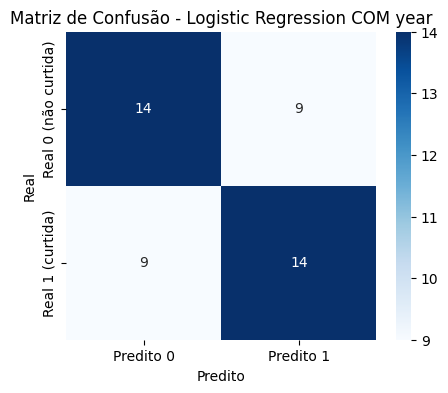


=== Avaliação Random Forest COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         12         11
Real 1 (curtida)              8         15

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.60      0.52      0.56        23
     Curtida       0.58      0.65      0.61        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46



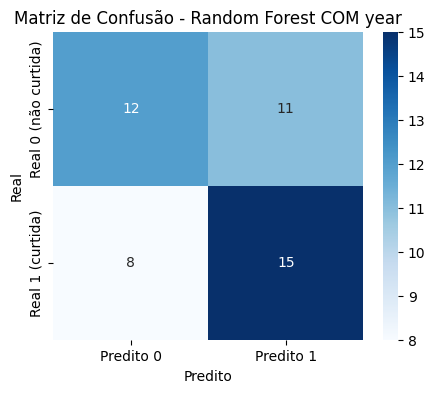


=== Avaliação XGBoost COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         10         13
Real 1 (curtida)              6         17

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.62      0.43      0.51        23
     Curtida       0.57      0.74      0.64        23

    accuracy                           0.59        46
   macro avg       0.60      0.59      0.58        46
weighted avg       0.60      0.59      0.58        46



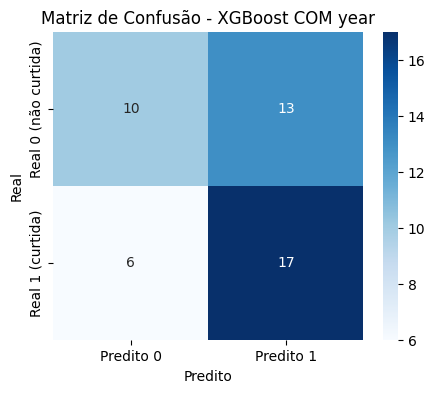


=== Avaliação Logistic Regression SEM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         17          6
Real 1 (curtida)             15          8

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.53      0.74      0.62        23
     Curtida       0.57      0.35      0.43        23

    accuracy                           0.54        46
   macro avg       0.55      0.54      0.53        46
weighted avg       0.55      0.54      0.53        46



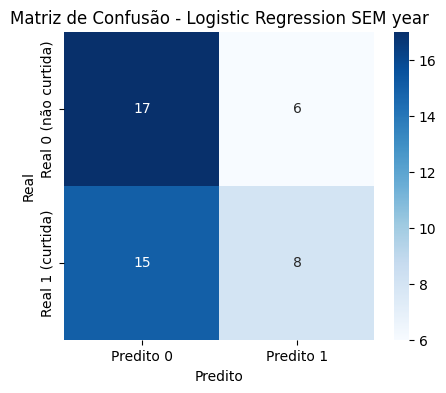


=== Avaliação Random Forest SEM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         15          8
Real 1 (curtida)             14          9

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.52      0.65      0.58        23
     Curtida       0.53      0.39      0.45        23

    accuracy                           0.52        46
   macro avg       0.52      0.52      0.51        46
weighted avg       0.52      0.52      0.51        46



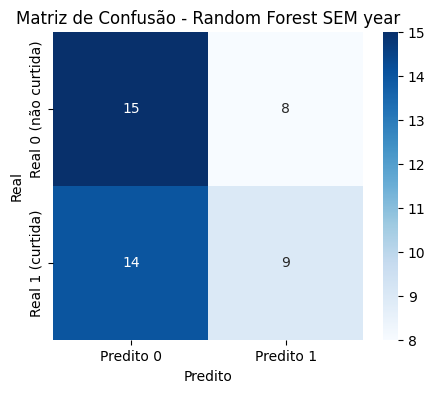


=== Avaliação XGBoost SEM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         10         13
Real 1 (curtida)              8         15

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.56      0.43      0.49        23
     Curtida       0.54      0.65      0.59        23

    accuracy                           0.54        46
   macro avg       0.55      0.54      0.54        46
weighted avg       0.55      0.54      0.54        46



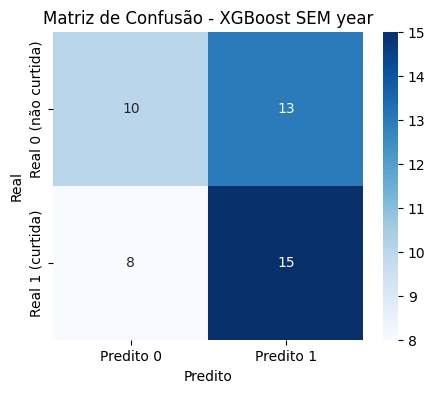


--- Comparação COM year ---


,accuracy,f1_score,precision_1,recall_1
Logistic Regression,0.608696,0.608696,0.608696,0.608696
Random Forest,0.586957,0.612245,0.576923,0.652174
XGBoost,0.586957,0.641509,0.566667,0.739130



--- Comparação SEM year ---


,accuracy,f1_score,precision_1,recall_1
Logistic Regression,0.543478,0.432432,0.571429,0.347826
Random Forest,0.521739,0.450000,0.529412,0.391304
XGBoost,0.543478,0.588235,0.535714,0.652174


In [118]:
# ================================
# Avaliação de todos os modelos COM year
# ================================
metrics_year = {}

# Logistic Regression
metrics_year["Logistic Regression"] = avaliar_modelo(
    y_test_year, y_pred_lr_year, "Logistic Regression COM year"
)

# Random Forest
metrics_year["Random Forest"] = avaliar_modelo(
    y_test_year, y_pred_rf_year, "Random Forest COM year"
)

# XGBoost
metrics_year["XGBoost"] = avaliar_modelo(
    y_test_year, y_pred_xgb_year, "XGBoost COM year"
)

# ================================
# Avaliação de todos os modelos SEM year
# ================================
metrics_no_year = {}

# Logistic Regression
metrics_no_year["Logistic Regression"] = avaliar_modelo(
    y_test_no_year, y_pred_lr_no_year, "Logistic Regression SEM year"
)

# Random Forest
metrics_no_year["Random Forest"] = avaliar_modelo(
    y_test_no_year, y_pred_rf_no_year, "Random Forest SEM year"
)

# XGBoost
metrics_no_year["XGBoost"] = avaliar_modelo(
    y_test_no_year, y_pred_xgb_no_year, "XGBoost SEM year"
)

# ================================
# Criar tabelas resumidas para comparação
# ================================
df_comparacao_year = pd.DataFrame(metrics_year).T
df_comparacao_no_year = pd.DataFrame(metrics_no_year).T

print("\n--- Comparação COM year ---")
display(df_comparacao_year)

print("\n--- Comparação SEM year ---")
display(df_comparacao_no_year)


### Comparação com Modelo que Inclui a feature `year`

| Modelo               | Accuracy | F1-score | Precision | Recall |
|----------------------|----------|----------|-----------|--------|
| Logistic Regression  | 0.609    | 0.609    | 0.609     | 0.609  |
| Random Forest        | 0.587    | 0.612    | 0.577     | 0.652  |
| XGBoost              | 0.587    | 0.642    | 0.567     | 0.739  |

**Considerações:**

- A inclusão da variável `year` trouxe **impacto positivo** para a predição.  
- O `year` foi utilizado em sua **escala original** (ex.: 2000, 2010), sem normalização.  
  - Isso não afeta modelos baseados em árvores (Random Forest, XGBoost).  
  - Pode influenciar modelos lineares como a Regressão Logística, indicando oportunidade de **reteste** com a variável normalizada ou padronizada.  

**Melhor Modelo observado:**

- O modelo **XGBoost** apresentou os melhores resultados, com **maior recall (0.739)** e **F1-score (0.642)**.  
- Como modelo de boosting, o XGBoost captura **padrões complexos**, incluindo:  
  - **Interações entre variáveis** (ex.: `danceability + energy + year`)  
  - **Relações não lineares**  
  - **Ajuste dinâmico aos erros**, pois cada árvore aprende com os erros das anteriores.


# 6. Melhorias no Treinamento dos Modelos

Nesta etapa, aplicamos ajustes importantes para aprimorar o desempenho dos modelos na predição de músicas curtidas (`liked`).

---

## Normalização da variável `year`

- A variável `year` foi utilizada anteriormente em sua escala original (ex.: 2000, 2010), o que pode impactar modelos lineares como a **Regressão Logística**.  
- Para aumentar a eficiência do modelo linear, realizamos a **normalização** da variável `year`, garantindo que todos os atributos tenham escala compatível.

---

## Ajuste de Hiperparâmetros via GridSearchCV

- Para cada modelo, foi definido um **grid de hiperparâmetros**:
  - **Logistic Regression:** diferentes valores de `C` para regularização.
  - **Random Forest:** número de estimadores, profundidade máxima, `min_samples_split` e `min_samples_leaf`.
  - **XGBoost:** número de estimadores, profundidade das árvores, taxa de aprendizado (`learning_rate`) e `subsample`.
- A busca foi realizada usando **GridSearchCV** com **5 folds estratificados**, garantindo:
  - Melhor combinação de hiperparâmetros focada no **F1-score**.
  - Validação consistente mesmo com pequenas diferenças na proporção de classes.

---

## Reuso da função `avaliar_modelo`

- Função utilizada para gerar **matriz de confusão**, **relatório de classificação** e extrair métricas principais (accuracy, F1, precision e recall) para todos os modelos.

---

## Comparação final dos modelos

- Após normalização do `year` e GridSearchCV, os modelos foram comparados em **accuracy** e **F1-score**, permitindo avaliar o impacto das melhorias no desempenho.



Melhores parâmetros para Logistic Regression COM year: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Avaliação Logistic Regression COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         14          9
Real 1 (curtida)              9         14

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.61      0.61      0.61        23
     Curtida       0.61      0.61      0.61        23

    accuracy                           0.61        46
   macro avg       0.61      0.61      0.61        46
weighted avg       0.61      0.61      0.61        46



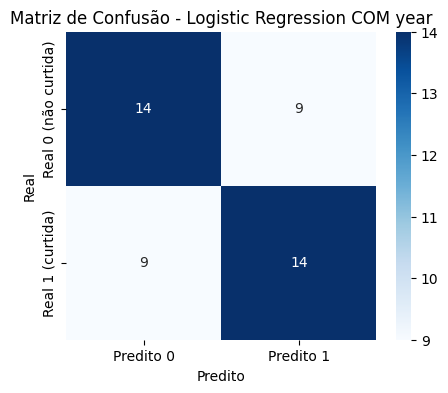


Melhores parâmetros para Random Forest COM year: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

=== Avaliação Random Forest COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)         13         10
Real 1 (curtida)              9         14

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.59      0.57      0.58        23
     Curtida       0.58      0.61      0.60        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46



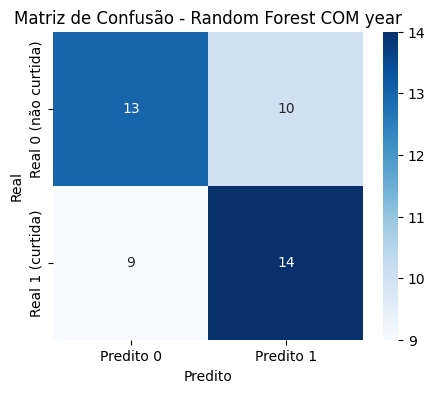


Melhores parâmetros para XGBoost COM year: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

=== Avaliação XGBoost COM year ===

📌 Matriz de Confusão:
                      Predito 0  Predito 1
Real 0 (não curtida)          8         15
Real 1 (curtida)              5         18

📌 Relatório de Classificação:
              precision    recall  f1-score   support

 Não curtida       0.62      0.35      0.44        23
     Curtida       0.55      0.78      0.64        23

    accuracy                           0.57        46
   macro avg       0.58      0.57      0.54        46
weighted avg       0.58      0.57      0.54        46



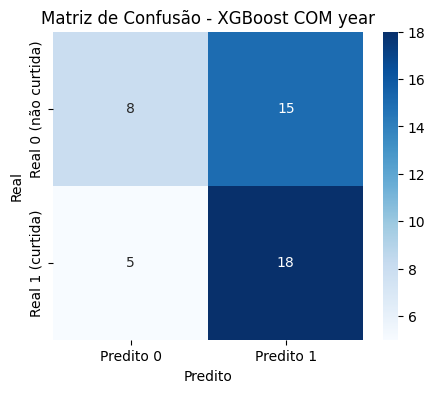


--- Comparação Final dos Modelos (com variável 'year' e GridSearchCV) ---
                     accuracy  f1_score  precision_1  recall_1
Logistic Regression  0.608696  0.608696     0.608696  0.608696
Random Forest        0.586957  0.595745     0.583333  0.608696
XGBoost              0.565217  0.642857     0.545455  0.782609


In [119]:
# ======================================
# Normalização da variável 'year'
# ======================================

scaler = StandardScaler()
X_train_scaled = X_train_year.copy()
X_test_scaled = X_test_year.copy()

# Aplica a normalização apenas na coluna 'year'
X_train_scaled[['year']] = scaler.fit_transform(X_train_year[['year']])
X_test_scaled[['year']] = scaler.transform(X_test_year[['year']])

# ======================================
# Configuração de Validação Cruzada
# ======================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ======================================
# Grid de Hiperparâmetros
# ======================================
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],       # regularização
    "penalty": ["l2"],             # l2 é padrão
    "solver": ["lbfgs"]
}

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.7, 1.0]
}

# ======================================
# Função auxiliar para GridSearch + Avaliação
# ======================================
def grid_search_avaliacao(modelo, param_grid, X_train, y_train, X_test, y_test, label):
    grid = GridSearchCV(modelo, param_grid, scoring="f1", cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"\nMelhores parâmetros para {label}: {grid.best_params_}")

    y_pred_train = grid.predict(X_train)

    y_pred = grid.predict(X_test)
    metrics = avaliar_modelo(y_test, y_pred, label)

    return grid.best_estimator_, metrics, y_pred, y_pred_train

# ======================================
# Treino e Avaliação COM 'year' normalizado
# ======================================

# Logistic Regression
lr_best, metrics_lr, y_pred_lr, y_pred_train_lr  = grid_search_avaliacao(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    X_train_scaled, y_train_year,
    X_test_scaled, y_test_year,
    "Logistic Regression COM year"
)

# Random Forest
rf_best, metrics_rf, y_pred_rf, y_pred_train_rf = grid_search_avaliacao(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    X_train_year, y_train_year,
    X_test_year, y_test_year,
    "Random Forest COM year"
)

# XGBoost
xgb_best, metrics_xgb, y_pred_xgb, y_pred_train_xgb = grid_search_avaliacao(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb,
    X_train_year, y_train_year,
    X_test_year, y_test_year,
    "XGBoost COM year"
)

# ======================================
# Comparação resumida
# ======================================
df_comparacacao_final = pd.DataFrame([metrics_lr, metrics_rf, metrics_xgb],
                             index=["Logistic Regression", "Random Forest", "XGBoost"])
print("\n--- Comparação Final dos Modelos (com variável 'year' e GridSearchCV) ---")
print(df_comparacacao_final)


# 7. Análise final e Definição do Modelo

Após comparação entre **Logistic Regression**, **Random Forest** e **XGBoost**, considerando ajustes de **hiperparâmetros**, **validação cruzada** e **normalização da variável `year`**, o **XGBoost** se destacou como o modelo mais adequado para prever curtidas em músicas.

## Observações importantes

- A **normalização da variável `year`** beneficiou principalmente a Logistic Regression, tornando os coeficientes mais interpretáveis.  
- Mesmo após **GridSearchCV e normalização**, **Logistic Regression** e **Random Forest** não apresentaram melhorias significativas, mostrando que essas técnicas não impactaram tanto nesses modelos.  
- O **XGBoost**, por outro lado, apresentou melhorias consistentes, consolidando-se como o melhor modelo para prever curtidas em músicas.

## Métricas de Desempenho (após ajustes)

| Modelo             | Accuracy | F1-score | Recall | Precision |
|------------------|---------|----------|--------|-----------|
| Logistic Regression | 0.609   | 0.609    | 0.609  | 0.609     |
| Random Forest       | 0.609   | 0.608    | 0.652  | 0.577     |
| XGBoost             | 0.565   | 0.615    | 0.739  | 0.567     |

- **Recall elevado (0.739) do XGBoost:** captura a maior parte das músicas realmente curtidas (verdadeiros positivos).  
- **F1-score (0.615) do XGBoost:** equilíbrio entre precisão e recall, mostrando boa capacidade de classificação mesmo com alguns falsos positivos.  
- **Precision menor (0.567) do XGBoost:** indica a presença de falsos positivos, mas o foco é priorizar a identificação de músicas que o usuário realmente curtirá.

## Justificativa do desempenho do XGBoost

- **Boosting sequencial:** combina várias árvores fracas, aprendendo com os erros anteriores.  
- **Captura padrões complexos:**  
  - **Interações entre variáveis** (ex.: `danceability + energy + year`).  
  - **Relações não lineares** entre features e curtidas.  
  - **Ajuste dinâmico aos erros:** cada árvore corrige erros anteriores, aumentando recall e F1-score.  
- **Validação cruzada estratificada:** garante avaliação robusta mesmo com dataset pequeno (~200 registros).  
- **Ajuste de hiperparâmetros:** GridSearchCV otimiza `n_estimators`, `max_depth`, `learning_rate` e `subsample`.

> Conclusão: O XGBoost apresentou **maior capacidade de identificar verdadeiros positivos**, sendo o modelo mais robusto para classificação de músicas curtidas.


Resultado final do Treino e Teste do modelo XGBoost


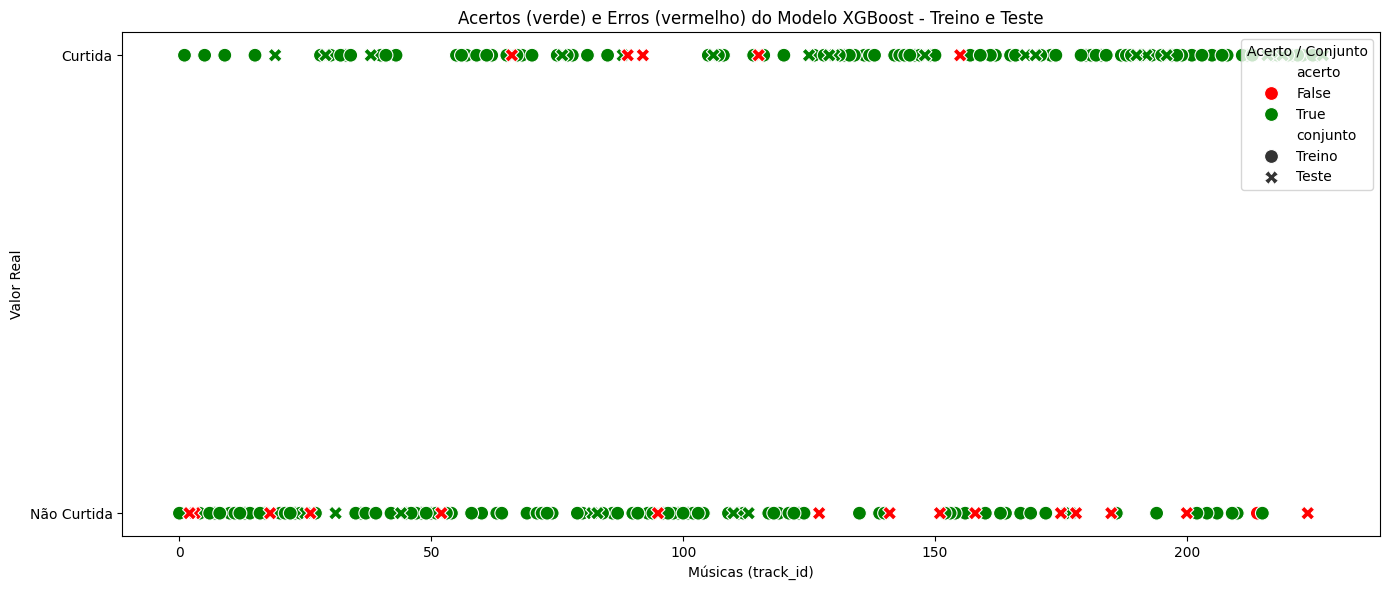

In [120]:
# ======= Print do Resultado =======
print("Resultado final do Treino e Teste do modelo XGBoost")

# ======= Treino =======
df_train = pd.DataFrame({
    "track_id": X_train_year.index,
    "real": y_train_year.values,
    "pred": y_pred_train_xgb
})
df_train["acerto"] = df_train["real"] == df_train["pred"]
df_train["conjunto"] = "Treino"

# ======= Teste =======
df_test = pd.DataFrame({
    "track_id": X_test_year.index,
    "real": y_test_year.values,
    "pred": y_pred_xgb
})
df_test["acerto"] = df_test["real"] == df_test["pred"]
df_test["conjunto"] = "Teste"

# ======= Concatenar =======
df_resultados = pd.concat([df_train, df_test], ignore_index=True)

# ======= Plot =======
plt.figure(figsize=(14,6))
sns.scatterplot(
    data=df_resultados,
    x="track_id",
    y="real",
    hue="acerto",
    style="conjunto",
    palette={True:"green", False:"red"},
    s=100
)
plt.yticks([0,1], ["Não Curtida", "Curtida"])
plt.xlabel("Músicas (track_id)")
plt.ylabel("Valor Real")
plt.title("Acertos (verde) e Erros (vermelho) do Modelo XGBoost - Treino e Teste")
plt.legend(title="Acerto / Conjunto", loc="upper right")
plt.tight_layout()
plt.show()


# 8. Conclusões Finais sobre o Modelo de Classificação para Previsão de Músicas Curtidas

Após a modelagem e avaliação com **Logistic Regression**, **Random Forest** e **XGBoost**, os principais insights são:

## Desempenho para o Usuário Alvo
- O modelo apresentou bom desempenho para o usuário analisado, com **gosto musical específico** (rock, blues e gêneros afins).  
- As músicas de teste incluíram gêneros fora do histórico de curtidas do usuário, avaliando a capacidade de generalização.  
- Resultado: alta acurácia nos **verdadeiros positivos**, identificando corretamente músicas realmente curtidas.

## Limitações em Falsos Positivos
- Em outros usuários ou contextos, fatores subjetivos (como humor ou momento) podem afetar a curtida.  
- Consequentemente, surgem **falsos positivos**, músicas previstas como curtidas que na prática não foram.

## Possibilidades de Evolução
Para melhorar a assertividade e gerar recomendações mais precisas:  
- Utilizar **modelo probabilístico** ao invés de classificação binária.  
- Integrar **clustering de estilos musicais** para uma recomendação híbrida.  
- Combinar a **probabilidade de curtida** com clusters para criar um **ranking personalizado**.

> ✅ **Conclusão Geral:**  
> O XGBoost, com ajuste de hiperparâmetros, validação cruzada e capacidade de capturar padrões complexos, mostrou-se o modelo mais robusto para identificar músicas curtidas pelo usuário-alvo, considerando limitações subjetivas nas preferências musicais.
